This notebook merges the 9 2014 NAIP Utah data into a mosaic and computes the NDVI of the mosaic. It also crops the mosaic to the site boundary and saves that to a tif file.

In [1]:
# Import packages and set working directory if needed here
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
from rasterio.merge import merge
from rasterio.plot import show # may not keep this import, checking the what the mosaic looks like (https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html)
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.clip as cl
from shapely.geometry import mapping, box
from shapely.geometry import Polygon

# set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Open site boundary shapefile
clip_out_path = "data/final-project/cottonwood-heights-utah/vector-clip/utah-avalanche-clip.shp"
avalanche_boundary = gpd.read_file(clip_out_path)

## Merge all scenes together into one array

In [3]:
# Create output file name path
out_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2014_mosaic.tif"

# If the output file doesn't already exist, create it
if os.path.exists(out_fp) == False:
    
    # Create list of files to merge
    src_data_dir = "data/final-project/cottonwood-heights-utah/naip/20140701/"
    search_criteria = "m*.tif"
    file_list = glob(os.path.join(src_data_dir, search_criteria))

    # Open each file in rasterio
    # Create an empty list that will hold all the opened files
    src_files_to_mosaic = []

    # Loop through and open each file and add it to the mosaic list
    for file in file_list:
        src = rio.open(file)
        src_files_to_mosaic.append(src)

    # Using rasterio.merge, merge all files into one array
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Write the mosaic to an output file
    # Set up the metadata for the output file
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans,
                     "crs": src.crs})

    with rio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

In [4]:
# Do a quick plot of the mosaic
#show(mosaic)

## Open and Plot the Mosaic

In [5]:
with rio.open(out_fp) as mosaic_2014_src:
    mosaic_2014_scene = mosaic_2014_src.read()
    mosaic_2014_scene_meta = mosaic_2014_src.meta
    mosaic_2014_scene_bds = mosaic_2014_src.bounds

In [6]:
type(mosaic_2014_scene_bds)

rasterio.coords.BoundingBox

In [7]:
mosaic_extent = plotting_extent(mosaic_2014_src)
mosaic_extent

(436149.0, 452772.0, 4483105.0, 4504638.0)

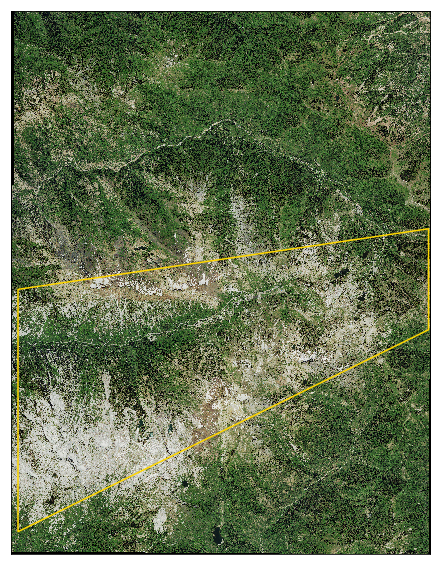

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot RGB of the mosaic
es.plot_rgb(mosaic_2014_scene,
            rgb=[0, 1, 2],
            extent=plotting_extent(mosaic_2014_src),
            ax=ax1)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="gold")

plt.show()

In [9]:
# Open avalanche paths
avalanche_paths_filename = glob(os.path.join(
    'data', 'final-project', 'cottonwood-heights-utah', 'avalanche-paths', '*.shp'))
avalanche_paths = gpd.read_file(avalanche_paths_filename[0])

# Clip data to boundary
avalanche_clip = cl.clip_shp(avalanche_paths, avalanche_boundary)

In [10]:
avalanche_boundary

,poly_no,geometry
0,1,"POLYGON ((436438 4484000, 436438 4493600, 4527..."


## Compute NDVI of the Mosaic

In [11]:
# Convert the data to int to avoid the divide by zero error
mosaic_2014_scene = mosaic_2014_scene.astype(int)
# Compute NDVI
ndvi_mosaic = es.normalized_diff(b2=mosaic_2014_scene[3], b1=mosaic_2014_scene[2])

C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\earthpy\spatial.py:75: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b2 - b1) / (b2 + b1)


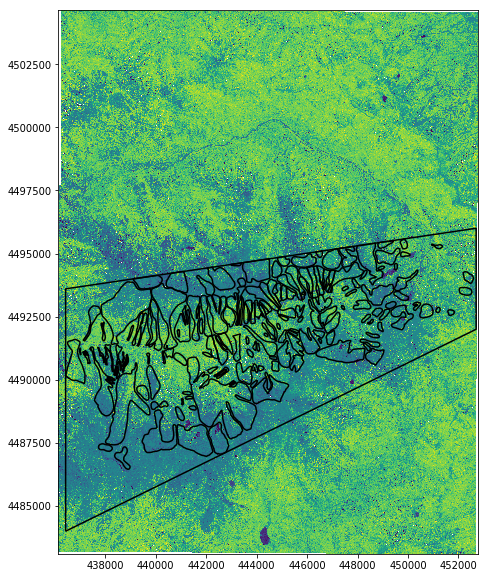

In [12]:
# Plot the NDVI mosaic
fig, ax1 = plt.subplots(figsize=(10, 10))
mos = ax1.imshow(ndvi_mosaic, extent=mosaic_extent)
# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="black")
avalanche_clip.boundary.plot(ax=ax1, color="black")
plt.show()

## Clip the mosaic to the site boundary

In [13]:
with rio.open(out_fp) as mosaic_2014_src:
    mosaic_2014_crop, mosaic_2014_meta = es.crop_image(
        mosaic_2014_src, avalanche_boundary)
    mosaic_2014_extent = plotting_extent(
        mosaic_2014_crop[0], mosaic_2014_meta['transform'])

## Plot RGB image of clipped mosaic

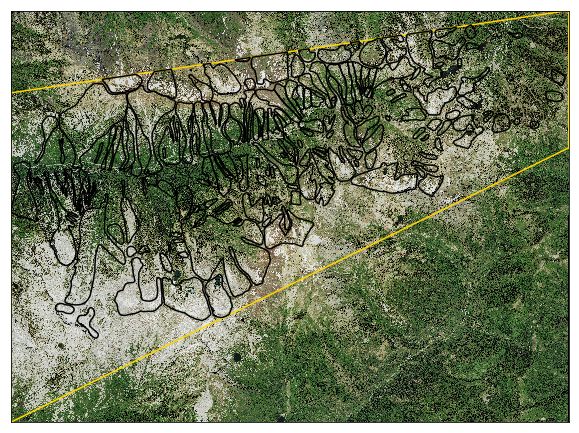

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot RGB of the cropped mosaic
es.plot_rgb(mosaic_2014_crop,
            rgb=[0, 1, 2],
            extent=mosaic_2014_extent,
            ax=ax1)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="gold")
avalanche_clip.boundary.plot(ax=ax1, color="black")

plt.show()

## Write cropped mosaic to tif file and plot it to verify it looks correct

In [15]:
# Write the cropped mosaic to an output file if it doesn't already exist
# Set up file name to output to
crop_2014_fn = 'data/final-project/cottonwood-heights-utah/naip/outputs/naip_2014_mosaic_crop.tif'

if os.path.exists(crop_2014_fn) == False:
    
    # Set up the metadata for the output file
    out_meta_crop = mosaic_2014_src.meta.copy()
    out_meta_crop.update({"driver": "GTiff",
                     "height": mosaic_2014_crop.shape[1],
                     "width": mosaic_2014_crop.shape[2],
                     "transform": mosaic_2014_meta['transform'],
                     "crs": mosaic_2014_src.crs})

    with rio.open(crop_2014_fn, "w", **out_meta_crop) as dest:
        dest.write(mosaic_2014_crop)